## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calibrate camera

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [3]:
mtx

array([[  1.15777818e+03,   0.00000000e+00,   6.67113857e+02],
       [  0.00000000e+00,   1.15282217e+03,   3.86124583e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [4]:
dist

array([[-0.24688507, -0.02373156, -0.00109831,  0.00035107, -0.00259866]])

In [5]:
# TODO: use getOptimalNewCameraMatrix() to refine mtx?

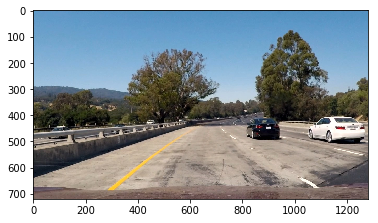

In [6]:
img = mpimage.imread('./test_images/test1.jpg')
plt.imshow(img)

## Undistort image

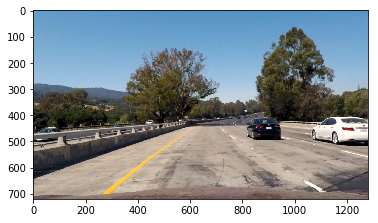

In [7]:
undist = cv2.undistort(img, mtx, dist, None, None)
plt.imshow(undist)

## Convert to grayscale

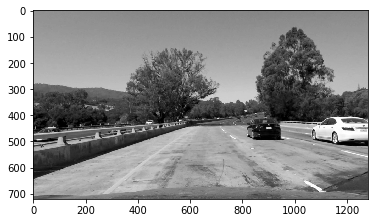

In [8]:
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

## Apply gradient thresholds

In [9]:
# TODO: Apply threshold to direction of the gradient
# TODO: try changing kernel size
# TODO: try changing thresholds

In [10]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8((255*abs_sobel) / np.max(abs_sobel))
    
    binary_output = np.zeros_like(gray)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

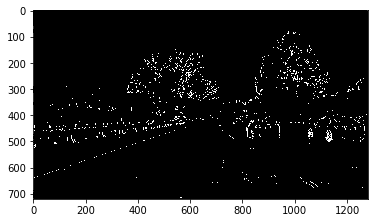

In [11]:
sobelx_thresh = abs_sobel_thresh(img, 'x', 40, 200)
plt.imshow(sobelx_thresh, cmap='gray')

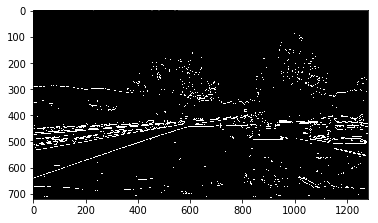

In [12]:
sobely_thresh = abs_sobel_thresh(img, 'y', 40, 200)
plt.imshow(sobely_thresh, cmap='gray')

In [13]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

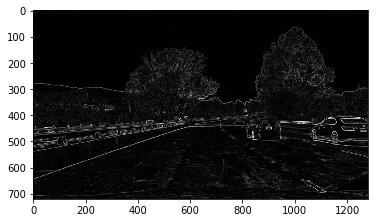

In [14]:
sobel = np.sqrt(sobelx**2 + sobely**2)
sobel = np.uint8((255*sobel) / np.max(sobel))
plt.imshow(sobel, cmap='gray')

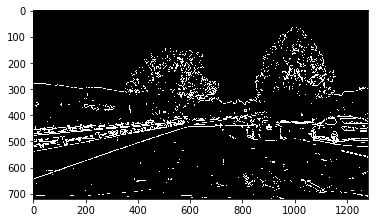

In [15]:
sobel_thresh = np.zeros_like(gray)
sobel_thresh[(sobel >= 40) & (sobel <= 200)] = 1
plt.imshow(sobel_thresh, cmap='gray')

In [16]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=15)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=15)

In [17]:
abs_sobelx = np.absolute(sobelx)
abs_sobely = np.absolute(sobely)

In [18]:
direction = np.arctan2(abs_sobely, abs_sobelx)

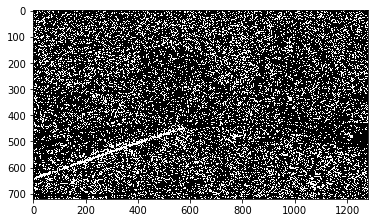

In [19]:
direction_thresh = np.zeros_like(gray)
direction_thresh[(direction >= 1) & (direction <= 1.3)] = 1
plt.imshow(direction_thresh, cmap='gray')

## Apply color thresholds

In [20]:
# TODO: try applying thresholds to RGB and other color spaces

In [21]:
hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h_channel = hls_image[:, :, 0]
l_channel = hls_image[:, :, 1]
s_channel = hls_image[:, :, 2]

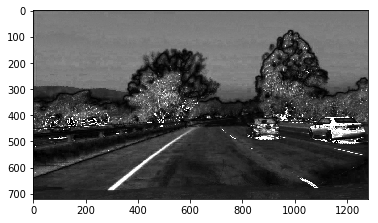

In [22]:
plt.imshow(hls_image[:, :, 2], cmap='gray')

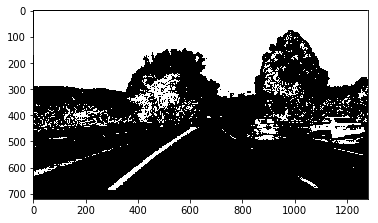

In [23]:
hls_thresh = np.zeros_like(gray)
hls_thresh[(s_channel >= 90) & (s_channel <= 255)] = 1
plt.imshow(hls_thresh, cmap='gray')

## Applying all thresholds

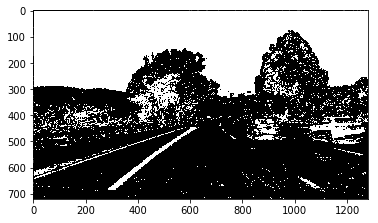

In [24]:
thresh_img = np.zeros_like(gray)
condition = ((((sobelx_thresh == 1) | (sobely_thresh == 1) | (sobel_thresh == 1)) & (direction_thresh == 1)) | (hls_thresh == 1))
thresh_img[condition] = 1
plt.imshow(thresh_img, cmap='gray')

## Perspective transform

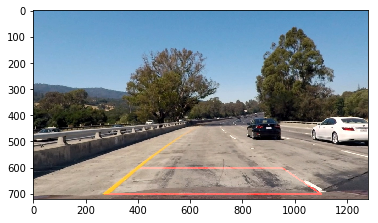

In [25]:
poly_img = np.zeros_like(undist)
pts = [(275, 700), (400, 600), (950, 600), (1100, 700)]
cv2.line(poly_img, pts[0], pts[1], (255, 0, 0), 5)
cv2.line(poly_img, pts[1], pts[2], (255, 0, 0), 5)
cv2.line(poly_img, pts[2], pts[3], (255, 0, 0), 5)
cv2.line(poly_img, pts[3], pts[0], (255, 0, 0), 5)
# cv2.polylines(poly_img, [pts], True, (255, 0, 0))

undist_copy = cv2.addWeighted(undist, 1, poly_img, 1, 0)
plt.imshow(undist_copy)

In [26]:
# src = np.float32([[275, 700], [600, 450], [700, 450], [1100, 700]])
src = np.float32([[275, 700], [400, 600], [950, 600], [1100, 700]])
dst = np.float32([[450, 700], [450, 600], [900, 600], [900, 700]])

In [27]:
M = cv2.getPerspectiveTransform(src, dst)

In [28]:
M

array([[ -4.09090909e-01,  -1.63636364e+00,   9.20454545e+02],
       [  4.21884749e-15,  -2.25000000e+00,   1.05000000e+03],
       [  4.77048956e-18,  -2.50000000e-03,   1.00000000e+00]])

In [29]:
warped = cv2.warpPerspective(undist_copy, M, undist_copy.shape[1::-1], flags=cv2.INTER_LINEAR)

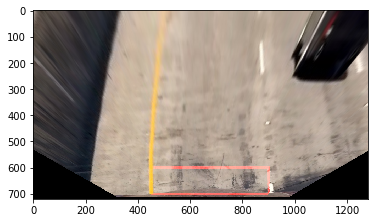

In [30]:
plt.imshow(warped)

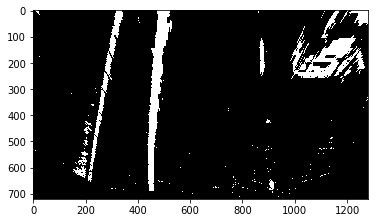

In [31]:
warped_edges = cv2.warpPerspective(thresh_img, M, thresh_img.shape[::-1], flags=cv2.INTER_LINEAR)
plt.imshow(warped_edges, cmap='gray')

## Histogram to find bottom of lane lines

In [32]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]

    histogram = np.sum(bottom_half, axis=0)    
    return histogram

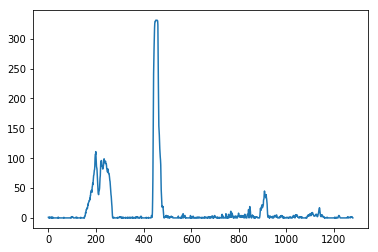

In [33]:
histogram = hist(warped_edges)
plt.plot(histogram)

In [34]:
left_x = np.argmax(histogram[:histogram.shape[0]//2])
left_x

451

In [35]:
right_x = histogram.shape[0]//2 + np.argmax(histogram[histogram.shape[0]//2:])
right_x

908

## Sliding window to find the lane lines

In [37]:
def find_lane_pixels_with_sliding_window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img = np.uint8(255*out_img / np.max(out_img))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & (nonzerox > win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & (nonzerox > win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) >= minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) >= minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_lines_with_sliding_window(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_with_sliding_window(binary_warped)
    return fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)

def fit_polynomial(img_shape, leftx, lefty, rightx, righty):
    # Find our lane pixels first
#     leftx, lefty, rightx, righty, out_img = find_lane_pixels_with_sliding_window(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0], dtype=np.int )
    try:
        left_fitx = (left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]).astype(np.int)
        right_fitx = (right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]).astype(np.int)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

def color_lane_pixels(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_with_sliding_window(binary_warped)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img

In [38]:
lanes_img = color_lane_pixels(warped_edges)

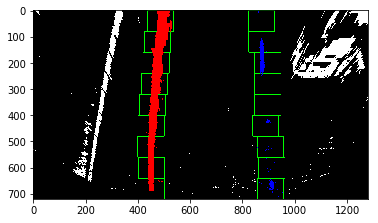

In [39]:
plt.imshow(lanes_img)

In [40]:
left_fitx, right_fitx, ploty = fit_lines_with_sliding_window(warped_edges)

## Inverse Perspective Transform

In [41]:
Minv = cv2.getPerspectiveTransform(dst, src)

In [42]:
Minv

array([[  4.07407407e-01,  -7.22222222e-01,   3.83333333e+02],
       [ -1.99840144e-15,  -4.44444444e-01,   4.66666667e+02],
       [ -3.25260652e-18,  -1.11111111e-03,   1.00000000e+00]])

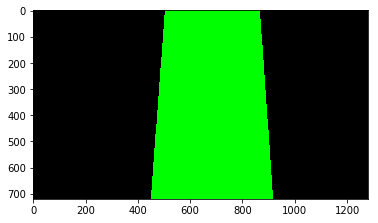

In [43]:
pts = np.array([[left_fitx[-1], ploty[-1]], [left_fitx[0], ploty[0]], [right_fitx[0], ploty[0]], [right_fitx[-1], ploty[-1]]])
lane_lines = np.zeros_like(undist)
cv2.fillPoly(lane_lines, [pts], color=(0, 255, 0))
plt.imshow(lane_lines)

In [44]:
lane_lines_warped = cv2.warpPerspective(lane_lines, Minv, lane_lines.shape[1::-1], flags=cv2.INTER_LINEAR)

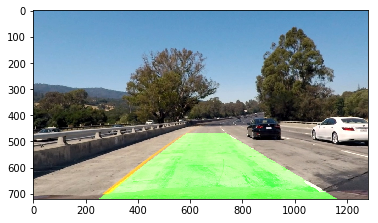

In [45]:
lines_detected_img = cv2.addWeighted(undist, 1, lane_lines_warped, 0.8, 0)
plt.imshow(lines_detected_img)

## Finding Radius of Curvature

In [46]:
x_m_per_pixel = 3.7/450
y_m_per_pixel = 30/720.0

In [47]:
center_fitx = (left_fitx + right_fitx) // 2
center_fit = np.polyfit(ploty, center_fitx, 2)
A, B = center_fit[0]*x_m_per_pixel/(y_m_per_pixel**2), center_fit[1]*x_m_per_pixel/y_m_per_pixel

y_eval = np.max(ploty)
R = ((1 + (2*A*y_eval + B)**2)**(3/2)) / (abs(2*A))
R

1652.6457891170214

## Finding offset

In [53]:
max_y_index = np.argmax(ploty)
offset = abs(x_m_per_pixel*(img.shape[1] - (left_fitx[max_y_index] + right_fitx[max_y_index]))/2.0)

## Showing radius of curvature and offset on lane detected image

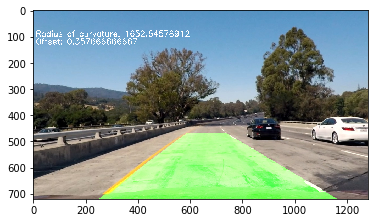

In [55]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfTextUpper = (10,100)
bottomLeftCornerOfTextLower = (10,130)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

lines_detected_img_annot = lines_detected_img.copy()

cv2.putText(lines_detected_img_annot,'Radius of curvature: ' + str(R), 
    bottomLeftCornerOfTextUpper, 
    font, 
    fontScale,
    fontColor,
    lineType)
cv2.putText(lines_detected_img_annot,'Offset: ' + str(offset), 
    bottomLeftCornerOfTextLower, 
    font, 
    fontScale,
    fontColor,
    lineType)
plt.imshow(lines_detected_img_annot)

## Detect lines in video

In [56]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [57]:
def fit_lines_from_prior(binary_warped):
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    
     # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fitted_x = left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2]
    right_fitted_x = right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + right_fit[2]
    
    leftx_left = left_fitted_x - margin
    leftx_right = left_fitted_x + margin
    
    rightx_left = right_fitted_x - margin
    rightx_right = right_fitted_x + margin
    
    left_lane_inds = ((nonzerox > leftx_left) & (nonzerox < leftx_right)).nonzero()[0]
    right_lane_inds = ((nonzerox > rightx_left) & (nonzerox < rightx_right)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fitx, right_fitx, ploty

In [58]:
def process_img(img):
    mtx = np.array([[1.15777818e+03, 0.00000000e+00, 6.67113857e+02],
       [0.00000000e+00, 1.15282217e+03, 3.86124583e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
    dist = np.array([[-0.24688507, -0.02373156, -0.00109831,  0.00035107, -0.00259866]])
    undist = cv2.undistort(img, mtx, dist, None, None)
    
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    sobelx_thresh = abs_sobel_thresh(img, 'x', 40, 200)
    sobely_thresh = abs_sobel_thresh(img, 'y', 40, 200)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = np.uint8((255*sobel) / np.max(sobel))
    
    sobel_thresh = np.zeros_like(gray)
    sobel_thresh[(sobel >= 40) & (sobel <= 200)] = 1
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=15)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=15)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    direction = np.arctan2(abs_sobely, abs_sobelx)
    direction_thresh = np.zeros_like(gray)
    direction_thresh[(direction >= 1) & (direction <= 1.3)] = 1
    
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_image[:, :, 2]
    hls_thresh = np.zeros_like(gray)
    hls_thresh[(s_channel >= 90) & (s_channel <= 255)] = 1
    
    thresh_img = np.zeros_like(gray)
    condition = ((((sobelx_thresh == 1) | (sobely_thresh == 1) | (sobel_thresh == 1)) & (direction_thresh == 1)) | (hls_thresh == 1))
    thresh_img[condition] = 1
    
    M = np.array([[-4.09090909e-01, -1.63636364e+00,  9.20454545e+02],
       [ 4.21884749e-15, -2.25000000e+00,  1.05000000e+03],
       [ 4.77048956e-18, -2.50000000e-03,  1.00000000e+00]])
    warped_edges = cv2.warpPerspective(thresh_img, M, thresh_img.shape[::-1], flags=cv2.INTER_LINEAR)
    
    if not left_line.detected:
        left_fitx, right_fitx, ploty = fit_lines_with_sliding_window(warped_edges)
        left_line.detected = True
        right_line.detected = True
    else:
        left_fitx, right_fitx, ploty = fit_lines_from_prior(warped_edges)
        
    left_line.current_fit = np.polyfit(ploty, left_fitx, 2)
    right_line.current_fit = np.polyfit(ploty, right_fitx, 2)
        
    pts = np.array([[left_fitx[-1], ploty[-1]], [left_fitx[0], ploty[0]], [right_fitx[0], ploty[0]], [right_fitx[-1], ploty[-1]]])
    lane_lines = np.zeros_like(undist)
    cv2.fillPoly(lane_lines, [pts], color=(0, 255, 0))
    
    Minv = np.array([[ 4.07407407e-01, -7.22222222e-01,  3.83333333e+02],
       [-1.99840144e-15, -4.44444444e-01,  4.66666667e+02],
       [-3.25260652e-18, -1.11111111e-03,  1.00000000e+00]])
    lane_lines_warped = cv2.warpPerspective(lane_lines, Minv, lane_lines.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(undist, 1, lane_lines_warped, 0.8, 0)
    
    x_m_per_pixel = 3.7/450
    y_m_per_pixel = 30/720.0
    
    center_fitx = (left_fitx + right_fitx) // 2
    center_fit = np.polyfit(ploty, center_fitx, 2)
    A, B = center_fit[0]*x_m_per_pixel/(y_m_per_pixel**2), center_fit[1]*x_m_per_pixel/y_m_per_pixel

    y_eval = np.max(ploty)
    R = ((1 + (2*A*y_eval + B)**2)**(3/2)) / (abs(2*A))
    
    max_y_index = np.argmax(ploty)
    offset = abs(x_m_per_pixel*(img.shape[1] - (left_fitx[max_y_index] + right_fitx[max_y_index]))/2.0)

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfTextUpper = (10,100)
    bottomLeftCornerOfTextLower = (10,130)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(result,'Radius of curvature: ' + str(R), 
        bottomLeftCornerOfTextUpper, 
        font, 
        fontScale,
        fontColor,
        lineType)
    cv2.putText(result,'Offset: ' + str(offset), 
        bottomLeftCornerOfTextLower, 
        font, 
        fontScale,
        fontColor,
        lineType)
    return result

In [59]:
left_line = Line()
right_line = Line()

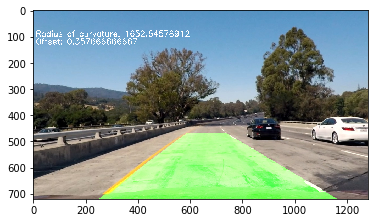

In [60]:
result = process_img(img)
plt.imshow(result)

In [61]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [62]:
white_output = "project_video_out.mp4"

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [11:58<00:00,  1.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 12min 3s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))